In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_pickle("weather")

In [3]:
df.head()

,_conds,_dewptm,_fog,_hail,_hum,_pressurem,_rain,_snow,_tempm,_thunder,_tornado
datetime_utc,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,27.0,1010.000000,0,0,30.0,0,0
1996-11-01 12:00:00,Smoke,10.0,0,0,32.0,2028.032149,0,0,28.0,0,0
1996-11-01 13:00:00,Smoke,11.0,0,0,44.0,2028.032149,0,0,24.0,0,0
1996-11-01 14:00:00,Smoke,10.0,0,0,41.0,1010.000000,0,0,24.0,0,0
1996-11-01 16:00:00,Smoke,11.0,0,0,47.0,1011.000000,0,0,23.0,0,0


In [4]:
df.drop(['_conds', '_dewptm', '_fog', '_hail', '_hum', '_pressurem', '_rain',
       '_snow', '_thunder', '_tornado'],inplace=True, axis=1)

In [5]:
df = df.resample('M').mean().fillna(method='pad')
train_df = df['1996':'2015'].resample('M').mean().fillna(method='pad')
test_df=df['2016':'2017'].resample('M').mean().fillna(method='pad')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
scaled_data = scaler.transform(df)
scaled_train_data = scaler.transform(train_df)
scaled_test_data = scaler.transform(test_df)

In [10]:
def generator(data):
    look_back=1
    g = TimeseriesGenerator(data, data, length=look_back, batch_size=3)
    return g

In [11]:
train_generator = generator(scaled_train_data)
test_generator = generator(scaled_test_data)

In [14]:
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [15]:
lstm_model.fit(train_generator,epochs=100,validation_data=test_generator,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 77 steps, validate for 5 steps
Epoch 1/100
77/77 [==============================] - 3s 39ms/step - loss: 0.1590 - val_loss: 0.1268
Epoch 2/100
77/77 [==============================] - 0s 5ms/step - loss: 0.0724 - val_loss: 0.0548
Epoch 3/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0427 - val_loss: 0.0345
Epoch 4/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0370 - val_loss: 0.0306
Epoch 5/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0358 - val_loss: 0.0288
Epoch 6/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0281
Epoch 7/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0340 - val_loss: 0.0277
Epoch 8/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0275
Epoch 9/100
77/77 [==============================] - 0s 6ms/step - loss: 0.0326 - val_loss: 0.0271
Epoch 10/100
77/7

In [16]:
lstm_pred_scaled = lstm_model.predict(generator(scaled_data))

In [17]:
lstm_predictions = scaler.inverse_transform(lstm_pred_scaled)

In [18]:
lstm_predictions = lstm_predictions.reshape(lstm_predictions.shape[0])

In [19]:
df1 = df[:-1]

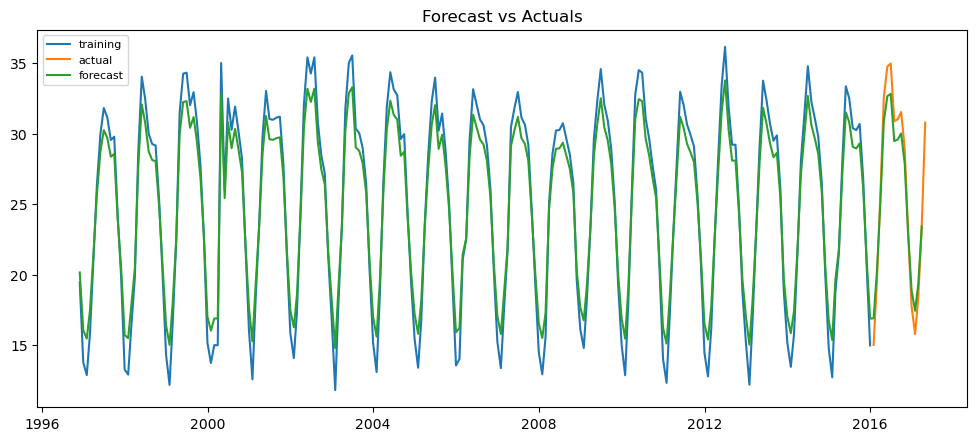

In [20]:
fc_series = pd.Series(lstm_predictions, index=df1.index)
#lower_series = pd.Series(conf[:, 0], index=test_df.index)
#upper_series = pd.Series(conf[:, 1], index=test_df.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df._tempm, label='training')
plt.plot(test_df._tempm, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()